In [1]:
import numpy as np
import torch
import torch.nn as nn
from core import VAE,RBFNN,VAE_RBF,utils,manifolds,geodesics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 0.92, '3D Sphere with Random Points')

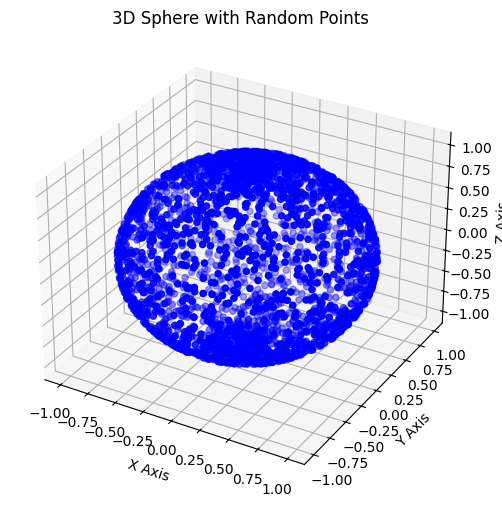

In [30]:
# Create a sphere with random points
num_points = 3000
phi = np.random.uniform(0, 2 * np.pi, num_points)
theta = np.random.uniform(0, np.pi, num_points)

# Convert spherical coordinates to Cartesian coordinates
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='blue', marker='o')

X_data = np.array([x,y,z]).T # (num_points,3)
y_data = np.zeros(num_points) # (num_points,)
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

plt.title('3D Sphere with Random Points')


Text(0.5, 0.92, 'Uniform 3D Sphere with Points')

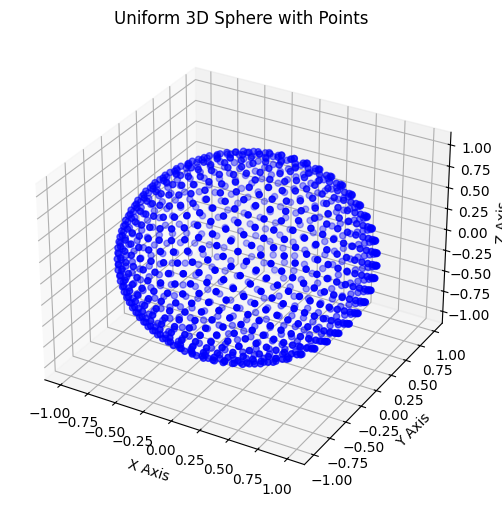

In [2]:
# Create a sphere with uniform points
num_points = 1000
indices = np.arange(0, num_points, dtype=float) + 0.5

phi = np.arccos(1 - 2*indices/num_points)
theta = np.pi * (1 + 5**0.5) * indices

# Convert spherical coordinates to Cartesian coordinates
x = np.cos(theta) * np.sin(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(phi)

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='blue', marker='o')

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

X_data = np.array([x,y,z]).T # (num_points,3)
y_data = np.zeros(num_points) # (num_points,)

plt.title('Uniform 3D Sphere with Points')

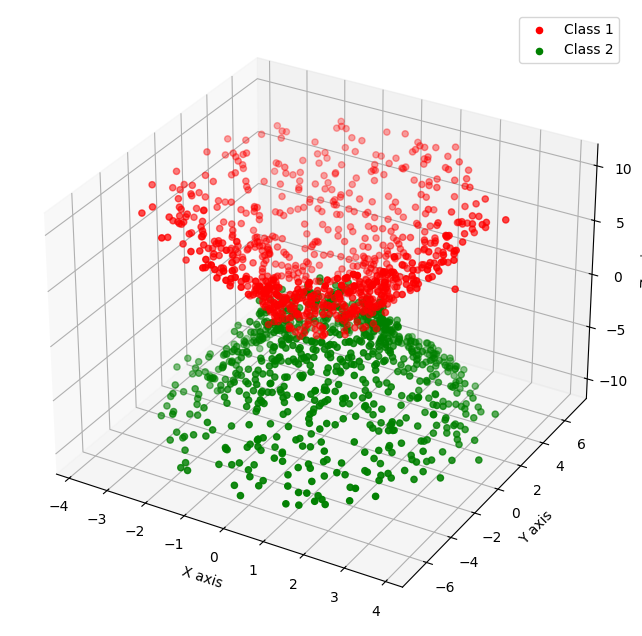

((1600, 3), (1600,))

In [2]:
def hyperboloid(a, b, c, min_z, max_z, size=100, noise=0.3):
    z = np.linspace(min_z, max_z, size)
    r = np.arcsinh(z/c)
    theta = np.random.uniform(0, 2*np.pi, size)
    x = a * np.cosh(r) * np.cos(theta)
    y = b * np.cosh(r) * np.sin(theta)
    # Adding some noise to the data
    x += np.random.normal(0, noise, size)
    y += np.random.normal(0, noise, size)
    z += np.random.normal(0, noise, size)
    return x, y, z

# Parameters for the hyperboloid
a, b, c = 1, 2, 3
size_per_class = 800 # 2000  # Number of points per class
z_min, z_max = -10, 10  # Range of z values

#Generate points for the hyperboloid (middle section, not a class itself)
x2, y2, z2 = hyperboloid(a, b, c, z_min, z_max, size=size_per_class)

# Generate points for class 1 (above the hyperboloid)
z1_min, z1_max = 0.1, z_max  # Slightly above the bottleneck to z_max
x1, y1, z1 = hyperboloid(a, b, c, z1_min, z1_max, size=size_per_class)

# Generate points for class 2 (below the hyperboloid)
z2_min, z2_max = z_min, -0.1  # z_min to slightly below the bottleneck
x2, y2, z2 = hyperboloid(a, b, c, z2_min, z2_max, size=size_per_class)


# Plot the data
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, color='r', label='Class 1')
ax.scatter(x2, y2, z2, color='g', label='Class 2')
# ax.scatter(x3, y3, z3, color='b', label='Class 3')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()

# Create a dataset
X_data = np.vstack((np.column_stack((x1, y1, z1)),
                          np.column_stack((x2, y2, z2)),))
                        #   np.column_stack((x3, y3, z3))))
y_data = np.array([1]*size_per_class + [2]*size_per_class)#+ [3]*size_per_class)

# Return dataset and labels
X_data.shape, y_data.shape

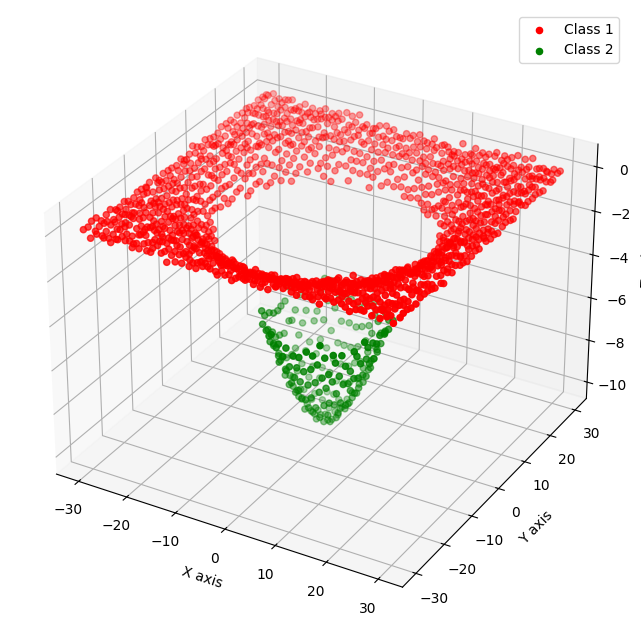

(1538, 3)
(1538,)


In [19]:
def gaussian_bell_3d(mu, sigma, size=1000, noise=0.1):
    # Create a grid of points
    x = np.linspace(-3*sigma, 3*sigma, int(np.sqrt(size)))
    y = np.linspace(-3*sigma, 3*sigma, int(np.sqrt(size)))
    x, y = np.meshgrid(x, y)
    x = x.ravel()
    y = y.ravel()
    # Calculate the z values on the bell curve
    z = -np.exp(-((x - mu)**2 + (y - mu)**2) / (2 * sigma**2))

    # Add noise
    x += np.random.normal(0, noise, x.shape)
    y += np.random.normal(0, noise, y.shape)
    z += np.random.normal(0, noise/10, z.shape)  # Less noise in the z to maintain the bell shape

    return x, y, z*sigma

# Parameters for the 3D Gaussian bell
mu = 0  # Mean of the distribution
sigma = 10  # Standard deviation of the distribution

# Generate points for the Gaussian bell
x, y, z = gaussian_bell_3d(mu, sigma, size=2000)

# exclude_mask = (z < -4) | (z > -2)

# # Apply the mask
# x = x[exclude_mask]
# y = y[exclude_mask]
# z = z[exclude_mask]

# Define the top part of the bell as one class and the rest as another
# Assume the top part is above a certain z threshold, arbitrarily chosen here as 0.5
# Classify points based on their z value (threshold at 0.5 of the max z value)

# threshold = min(z) * 0.15
# above_mask = z < threshold
# below_mask = z >= threshold


above_mask = z > -1.5
below_mask = z <= -5

x1, y1, z1 = x[above_mask], y[above_mask], z[above_mask]

x2, y2, z2 = x[below_mask], y[below_mask], z[below_mask]


# Plot the data
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, y1, z1, color='r', label='Class 1')
ax.scatter(x2, y2, z2, color='g', label='Class 2')
# ax.scatter(x3, y3, z3, color='b', label='Class 3')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()

# Create a dataset
X_data = np.vstack((np.column_stack((x1, y1, z1)),
                    np.column_stack((x2, y2, z2)),))


y_data = np.array([1]*len(x1) + [2]*len(x2))

# Return dataset and labels
print(X_data.shape)
print(y_data.shape)

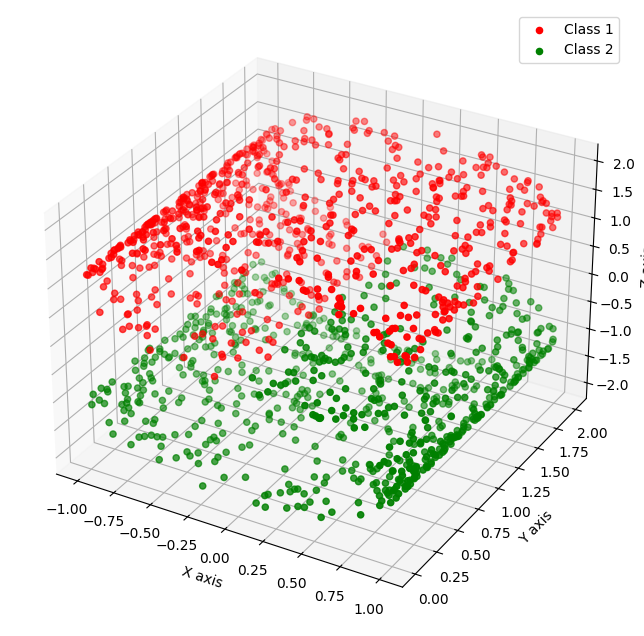

(1500, 3)
(1500,)


In [3]:
# S curve dataset
from sklearn import datasets, manifold
n_samples = 1500
S_points, _ = datasets.make_s_curve(n_samples, random_state=0)
above_mask = S_points[:,2] < 0
below_mask = S_points[:,2] >= 0
class1 = S_points[below_mask]
class2 = S_points[above_mask]

# Plot the data
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(class1[:,0],class1[:,1],class1[:,2], color='r', label='Class 1')
ax.scatter(class2[:,0],class2[:,1],class2[:,2], color='g', label='Class 2')
# ax.scatter(x3, y3, z3, color='b', label='Class 3')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()

# Create a dataset
X_data = np.vstack((class1,class2))
y_data = np.array([1]*len(class1) + [2]*len(class2))

# Return dataset and labels
print(X_data.shape)
print(y_data.shape)

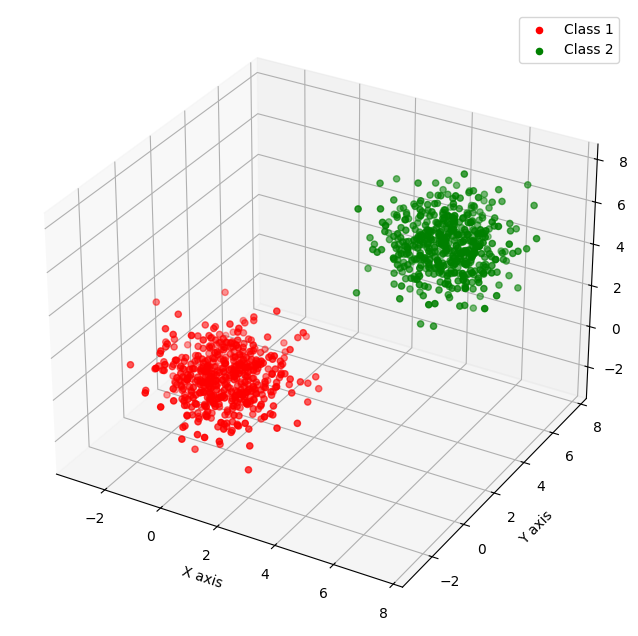

(1000, 3)
(1000,)


In [4]:
np.random.seed(0)  # For reproducibility

# Parameters for the first cluster
mean1 = [0, 0, 0]
cov1 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

# Parameters for the second cluster
mean2 = [5, 5, 5]
cov2 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

# Generate points for each cluster
class1 = np.random.multivariate_normal(mean1, cov1, 500)
class2 = np.random.multivariate_normal(mean2, cov2, 500)


# Plot the data
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(class1[:,0],class1[:,1],class1[:,2], color='r', label='Class 1')
ax.scatter(class2[:,0],class2[:,1],class2[:,2], color='g', label='Class 2')
# ax.scatter(x3, y3, z3, color='b', label='Class 3')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()

# Create a dataset
X_data = np.vstack((class1,class2))
y_data = np.array([1]*len(class1) + [2]*len(class2))

# Return dataset and labels
print(X_data.shape)
print(y_data.shape)

In [95]:
# Vérifie si CUDA (GPU support) est disponible
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU est disponible. Device:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU non disponible, utilisation du CPU")

GPU est disponible. Device: NVIDIA GeForce RTX 2070


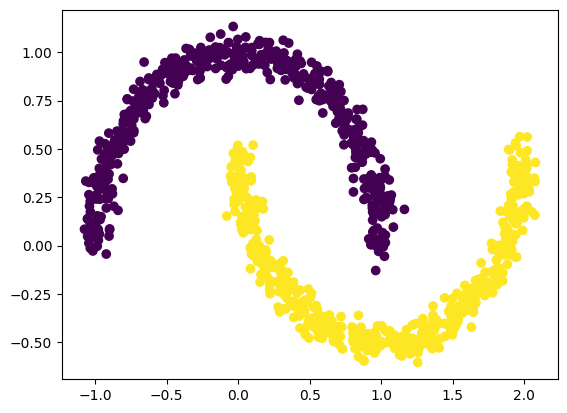

In [103]:
from sklearn import datasets, manifold, cluster

n_samples = 1000
moons, _ = datasets.make_moons(n_samples, random_state=0,noise=0.05)


X_data = moons


test = cluster.AgglomerativeClustering(n_clusters=2, linkage='single')
test.fit(X_data)
y_data = test.labels_

plt.scatter(moons[:,0],moons[:,1], c=y_data)

(1500, 3)


/tmp/ipykernel_2058/1812735065.py:57: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(above[:,0],above[:,1], above[:,2], c=default_colors[1])
/tmp/ipykernel_2058/1812735065.py:58: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(below[:,0],below[:,1], below[:,2], c=default_colors[0])


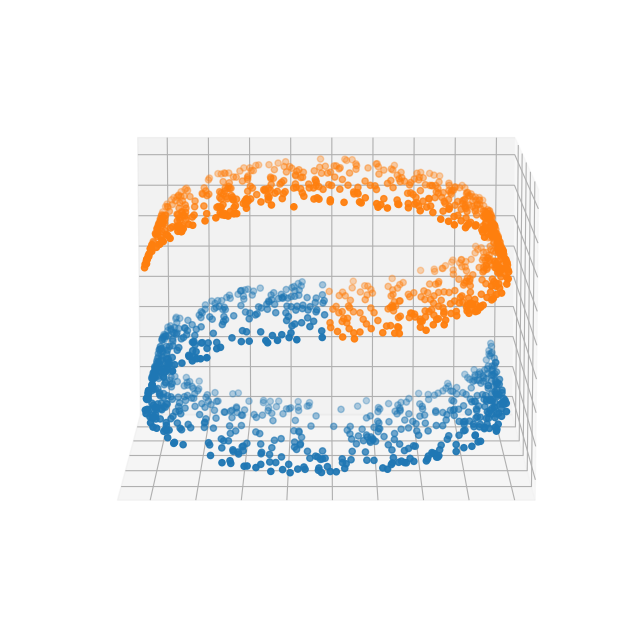

In [4]:
def normalize(X, mean3d, max_3d):
    X2 = np.empty_like(X)
    X2 = X - mean3d
    X2 = X2/max_3d
    return X2

def unnormalize(X, mean3d, max_3d):
    X2 = np.empty_like(X)
    X2 = X*max_3d
    X2 = X2 + mean3d
    return X2

def normalize_0_1(X, min_3d, max_3d):
    X2 = np.empty_like(X)
    X2 = (X - min_3d) / (max_3d - min_3d)
    return X2
def unnormalize_0_1(X, min_3d, max_3d):
    X2 = np.empty_like(X)
    X2 = X*(max_3d - min_3d) + min_3d
    return X2

# dataset class to efficiently extract the relevant labels and not make a copy of the entire dataset
class HyperboloidDataset(Dataset):
    def __init__(self, points, labels):
        # Extract only the data with the specified labels
        self.data = []
        points = torch.tensor(points, dtype=torch.float32)
        for point,label in zip(points,labels):
            self.data.append((point,label))

        self.points = [point for point, label in self.data]
        self.targets = [label for point, label in self.data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

min_3d = np.array([X_data[:,i].min() for i in range(X_data.shape[1])])
mean3d = np.array([X_data[:,i].mean() for i in range(X_data.shape[1])])
max_3d = np.array([np.max(np.abs(X_data[:, i])) for i in range(X_data.shape[1])])

X_data = normalize(X_data, mean3d, max_3d)
# X_data = normalize_0_1(X_data, min_3d, max_3d)
train_dataset = HyperboloidDataset(X_data, y_data)
default_colors = plt.get_cmap('tab10').colors
print(X_data.shape)
if X_data.shape[1] == 2:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(X_data[:,0],X_data[:,1], c=y_data)
elif X_data.shape[1] == 3:
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    above = X_data[y_data == 1]
    below = X_data[y_data == 2]
    ax.scatter(above[:,0],above[:,1], above[:,2], c=default_colors[1])
    ax.scatter(below[:,0],below[:,1], below[:,2], c=default_colors[0])
    # Sélectionner la vue
    ax.view_init(10, 90)
    # Masquer les lignes des axes
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.xaxis.line.set_linewidth(0)
    ax.yaxis.line.set_linewidth(0)
    ax.zaxis.line.set_linewidth(0)
    ax.tick_params(axis='x', which='both', length=0)
    ax.tick_params(axis='y', which='both', length=0)
    ax.tick_params(axis='z', which='both', length=0)
    color_tuple = (1.0, 1.0, 1.0, 0.0)
    ax.tick_params(color=color_tuple)
    # Afficher la grille mais pas les axes
    ax.grid(True)   



batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)

In [94]:
# Choice of the model and hyperparameters

input_dim = train_dataset[0][0].shape[-1]  # The dimension of the data
hidden_dims = [64, 32] #[64, 32]  # The dimension of the hidden layers
latent_dim = 2  # The latent space dimension
hidden_activation = nn.Tanh()  # The activation function of the hidden layers
encoder_output_mu_activation = nn.Identity() # Activation of the output of mu by the encoder
encoder_output_logvar_activation = nn.Softplus() # Activation of the output of logvar by the encoder
decoder_output_mu_activation =  nn.Tanh() # Activation of the output of mu by the decoder
decoder_output_logvar_activation = nn.Softplus() # Activation of the output of logvar by the decoder

# optimizer
#lambda_reg = 1e-7 # weight decay (l2 regulariztaion to the loss)
learning_rate = 1e-4

# training
# warmup = int(0.3 * epochs)
epochs = 200 #

In [53]:
# initilize model
model = VAE.VAE(input_dim, 
                hidden_dims, 
                latent_dim, 
                hidden_activation, 
                encoder_output_mu_activation,
                encoder_output_logvar_activation,
                decoder_output_mu_activation,
                decoder_output_logvar_activation)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

VAE(
  (encoder): VAE_encoder(
    (layers): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): Tanh()
    )
    (output_mu): Sequential(
      (0): Linear(in_features=32, out_features=2, bias=True)
      (1): Identity()
    )
    (output_logvar): Sequential(
      (0): Linear(in_features=32, out_features=2, bias=True)
      (1): Softplus(beta=1, threshold=20)
    )
  )
  (decoder): VAE_decoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): Tanh()
    )
    (output_mu): Sequential(
      (0): Linear(in_features=64, out_features=3, bias=True)
      (1): Tanh()
    )
    (output_logvar): Sequential(
      (0): Linear(in_features=64, out_features=3, bias=True)
      (1): Softplus(beta=1, threshold=20)
    )
  )
)


[Epoch: 0/200] [objective loss: 3.797]
Reconstruction loss: 3.2624621391296387
KL divergence loss: 0.3125428259372711
[Epoch: 20/200] [objective loss: 0.671]
Reconstruction loss: 0.7148793339729309
KL divergence loss: 0.007970109581947327
[Epoch: 40/200] [objective loss: 0.572]
Reconstruction loss: 0.5717120170593262
KL divergence loss: 0.0020804000087082386
[Epoch: 60/200] [objective loss: 0.553]
Reconstruction loss: 0.5682321786880493
KL divergence loss: 0.0009565395885147154
[Epoch: 80/200] [objective loss: 0.548]
Reconstruction loss: 0.5679833292961121
KL divergence loss: 0.0004911742289550602
[Epoch: 100/200] [objective loss: 0.545]
Reconstruction loss: 0.5962488055229187
KL divergence loss: 0.00027303610113449395
[Epoch: 120/200] [objective loss: 0.544]
Reconstruction loss: 0.47971630096435547
KL divergence loss: 0.00017610831127967685
[Epoch: 140/200] [objective loss: 0.543]
Reconstruction loss: 0.5261771082878113
KL divergence loss: 0.00010305429896106943
[Epoch: 160/200] [obje

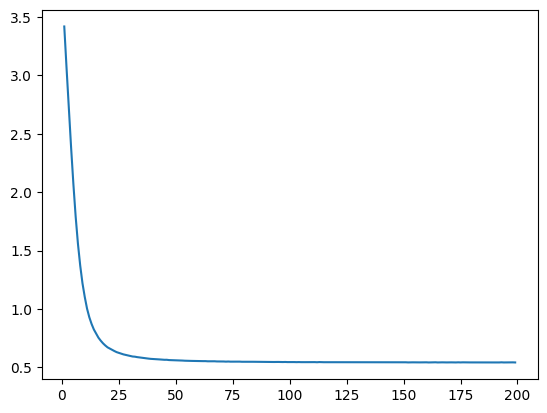

In [54]:
# Train the VAE with the new prior
ELBO_loss = []
for epoch in range(epochs):
    # Initialize the losses
    train_loss = 0.0

    for X_batch,y_batch in train_loader:
        # Forward pass
        MU_X_eval, LOG_VAR_X_eval, Z_ENC_eval, MU_Z_eval, LOG_VAR_Z_eval = model(X_batch)

        # Compute the regluarization parameter for the warmup
        # that forces the latent variables to follow the prior distribution
        # see the code of VAE_loss for more informations
        # r = min(1.0, epoch / warmup) if warmup > 0 else 0.0 

        # The VAE loss
        # loss = VAE.VAE_loss(x=X_batch, mu_x=MU_X_eval, log_var_x=LOG_VAR_X_eval,
        #                                 mu_z=MU_Z_eval, log_var_z=LOG_VAR_Z_eval, r=r)
        loss,reconstruction,kldiv = VAE.VAE_loss_2(x=X_batch, mu_x=MU_X_eval, log_var_x=LOG_VAR_X_eval,
                                        mu_z=MU_Z_eval, log_var_z=LOG_VAR_Z_eval)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Average loss for the epoch
    average_epoch_loss = train_loss / len(train_loader)
    ELBO_loss.append(average_epoch_loss)

    if epoch % 20 == 0:
        print(f"[Epoch: {epoch}/{epochs}] [objective loss: {average_epoch_loss:.3f}]")
        print(f"Reconstruction loss: {reconstruction}")
        print(f"KL divergence loss: {kldiv}")
    
ELBO_train = round(ELBO_loss[-1], 2)
print(f'[ELBO train: {ELBO_train}]')
print("Training finished")

plt.figure()
plt.plot(range(1, epochs), ELBO_loss[1:])
# plt.xlabel('Epochs')
# plt.ylabel('ELBO Loss')
plt.show()

In [55]:
# encode and decode the data and store the outputs of the model
# computed on the whole dataset
latent_means_list = []
latent_logvars_list = []
latent_z = []
output_means_list = []
output_logvars_list = []
labels_list = []


with torch.no_grad():  
    for imgs, labels_ in train_loader: 
        mu_x, log_var_x, z_enc, mu_z, log_var_z = model(imgs)
        z_rep = VAE.VAE.reparametrization_trick(mu_z, log_var_z)
        latent_means_list.append(mu_z)
        latent_logvars_list.append(log_var_z)
        latent_z.append(z_rep)
        output_means_list.append(mu_x)
        output_logvars_list.append(log_var_x)
        labels_list.append(labels_)



# Now we concatenate the list to form a single Tensor
latent_means = torch.cat(latent_means_list, dim=0)
latent_logvars = torch.cat(latent_logvars_list, dim=0)
latent_z = torch.cat(latent_z, dim=0)
output_means = torch.cat(output_means_list, dim=0)
output_logvars = torch.cat(output_logvars_list, dim=0)
labels = torch.cat(labels_list, dim=0)

[]

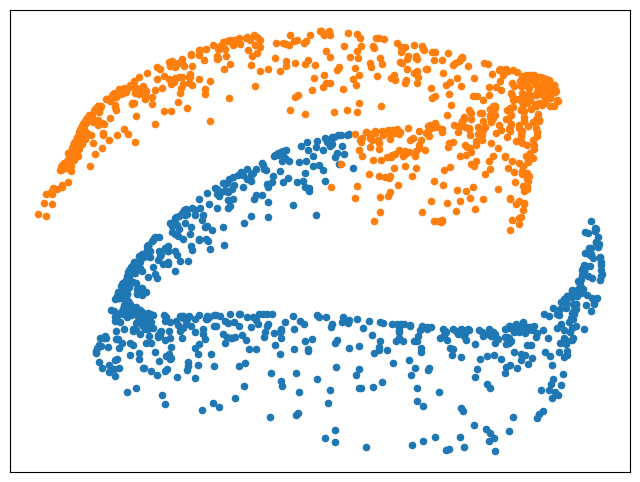

In [72]:
# utils.plot_latent_space(latent_means,labels)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)  # 2D scatter plot
for label in np.unique(labels):
    points = latent_means[labels == label]
    ax.scatter(points[:, 0], points[:, 1], s=20, label=f'Label {label}')
# Enlever les axes
ax.set_xticks([])
ax.set_yticks([])
# ax.set_xlabel('Latent Variable 1')
# ax.set_ylabel('Latent Variable 2')

Apply Kmeans to the latent space


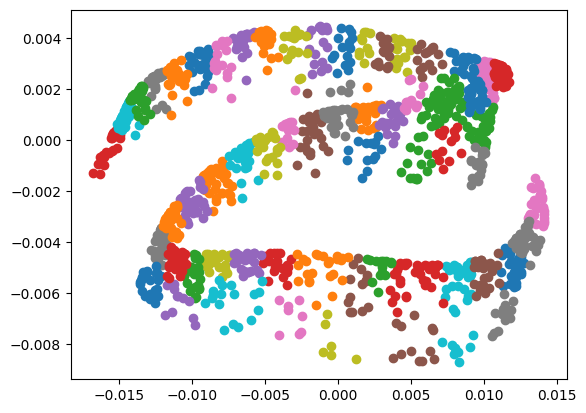

Compute the bandwidths for each centroids


In [58]:
# create RBF network
k_rbf = 64 #64
a = 1.25 #2
zeta_rbf = 1e-6 #1e-6
rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

# apply kmeans to the means of the latent space
print("Apply Kmeans to the latent space")
plt.figure()
centers_rbf,centers_ids = rbfnn.fit_kmeans(latent_means,display=True)
# compute the bandwidths for each centroids
print("Compute the bandwidths for each centroids")
lambdas_k = rbfnn.compute_bandwidth(latent_means)

[iter: 0/1000] [objective loss: 3.275176]
[iter: 20/1000] [objective loss: 2.342417]
[iter: 40/1000] [objective loss: 1.874981]
[iter: 60/1000] [objective loss: 1.558868]
[iter: 80/1000] [objective loss: 1.323458]
[iter: 100/1000] [objective loss: 1.139064]
[iter: 120/1000] [objective loss: 0.993595]
[iter: 140/1000] [objective loss: 0.874489]
[iter: 160/1000] [objective loss: 0.780234]
[iter: 180/1000] [objective loss: 0.702680]
[iter: 200/1000] [objective loss: 0.640565]
[iter: 220/1000] [objective loss: 0.590956]
[iter: 240/1000] [objective loss: 0.549699]
[iter: 260/1000] [objective loss: 0.517202]
[iter: 280/1000] [objective loss: 0.489298]
[iter: 300/1000] [objective loss: 0.468915]
[iter: 320/1000] [objective loss: 0.452839]
[iter: 340/1000] [objective loss: 0.436393]
[iter: 360/1000] [objective loss: 0.424612]
[iter: 380/1000] [objective loss: 0.415054]
[iter: 400/1000] [objective loss: 0.407588]
[iter: 420/1000] [objective loss: 0.401493]
[iter: 440/1000] [objective loss: 0.39

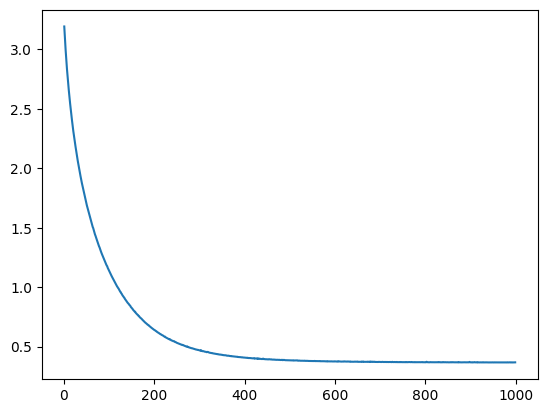

In [59]:
RBF_loss = []
nb_iters=1000
optimizer_rbf = torch.optim.Adam(rbfnn.parameters(), lr=2e-4, weight_decay=1e-7)

for iter in range(nb_iters):
    # Initialize the losses
    train_loss = 0.0

    permutation = np.random.permutation(len(train_dataset))

    for i in range(0, len(train_dataset), batch_size):
        # Forward pass in the model
        indices = permutation[i:i + batch_size]
        # get previously computed latent means and logvars
        LOG_VAR_X = output_logvars[indices, :]
        MU_Z = latent_means[indices, :]
 
        # Regress the output of the variance network
        LOG_VAR_X_eval_RBF = -torch.log(rbfnn(MU_Z)) # = log(1/beta_psi(z)) to have logvar

        loss = torch.nn.MSELoss(reduction='mean')(LOG_VAR_X, LOG_VAR_X_eval_RBF)
             
        # Backward pass
        optimizer_rbf.zero_grad()
        loss.backward()
        optimizer_rbf.step()

        # Ensure positivity of the weights
        rbfnn.W_rbf.data.clamp_(min=1e-5)
        train_loss += loss.item()

    # Average loss for the iter
    average_iter_loss = train_loss / len(train_loader)
    RBF_loss.append(average_iter_loss)

    if iter % 20 == 0:
        print(f"[iter: {iter}/{nb_iters}] [objective loss: {average_iter_loss:.6f}]")
    
RBF_train = round(RBF_loss[-1],6)
print(f'[ELBO train: {RBF_train}]')
print("Training finished")

plt.figure()
plt.plot(range(1, nb_iters), RBF_loss[1:])
plt.show()

In [60]:
# combine both model into one torch module
vae_rbf_model = VAE_RBF.VAE_RBF(model,rbfnn)
torch.save(vae_rbf_model.state_dict(), 'torch_models/S_test_2_vaerbfnn.pt')

In [5]:
# load the saved model
input_dim = train_dataset[0][0].shape[-1]  # The dimension of the data
hidden_dims = [64, 32]  # The dimension of the hidden layers
latent_dim = 2  # The latent space dimension
hidden_activation = nn.Tanh()  # The activation function of the hidden layers
encoder_output_mu_activation = nn.Identity() # Activation of the output of mu by the encoder
encoder_output_logvar_activation = nn.Softplus() # Activation of the output of logvar by the encoder
decoder_output_mu_activation = nn.Tanh() # Activation of the output of mu by the decoder
decoder_output_logvar_activation = nn.Softplus() # Activation of the output of logvar by the decoder

model_VAE = VAE.VAE(input_dim = input_dim, 
                hidden_dims = hidden_dims,
                latent_dim = latent_dim, 
                hidden_activation=hidden_activation, 
                encoder_output_mu_activation=encoder_output_mu_activation,
                encoder_output_logvar_activation=encoder_output_logvar_activation,
                decoder_output_mu_activation=decoder_output_mu_activation,
                decoder_output_logvar_activation=decoder_output_logvar_activation)

# create RBF network, choice of the hyperparameters
k_rbf = 64
a = 1.25
zeta_rbf = 1e-6
model_rbfnn = RBFNN.RBFNN(a=a,k_rbf=k_rbf,zeta_rbf=zeta_rbf,W_dim=input_dim,latent_dim=latent_dim)

# create VAE-RBF model
model_VAE_RBF = VAE_RBF.VAE_RBF(model_VAE,model_rbfnn)

model_VAE_RBF.load_state_dict(torch.load('../torch_models/VAE_RBFNN_S.pt'))

<All keys matched successfully>

In [6]:
# encode and decode the data and store the outputs of the model
# computed on the whole dataset
latent_means_list = []
latent_logvars_list = []
latent_z = []
output_means_list = []
output_logvars_list = []
labels_list = []

with torch.no_grad():  
    for imgs, labels_ in train_loader: 
        mu_x, log_var_x, z_enc, mu_z, log_var_z = model_VAE_RBF.VAE(imgs)
        z_rep = VAE.VAE.reparametrization_trick(mu_z, log_var_z)
        latent_means_list.append(mu_z)
        latent_logvars_list.append(log_var_z)
        latent_z.append(z_rep)
        output_means_list.append(mu_x)
        output_logvars_list.append(log_var_x)
        labels_list.append(labels_)

# Now we concatenate the list to form a single Tensor
latent_means = torch.cat(latent_means_list, dim=0)
latent_logvars = torch.cat(latent_logvars_list, dim=0)
latent_z = torch.cat(latent_z, dim=0)
output_means = torch.cat(output_means_list, dim=0)
output_logvars = torch.cat(output_logvars_list, dim=0)
labels = torch.cat(labels_list, dim=0)

construct solver graph
[Initialize Graph] [Processed point: 0/64]
Compute geodesic


/home/tdanielou/Code/MVA/Geometric-Data-Analysis/latent_space_oddity_MVA/core/custom_geodesics.py:72: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  curve_length_eval = integrate.quad(lambda t: local_length(metric, curve, t), a, b, epsabs=tol, limit=limit)  # , number of subintervals


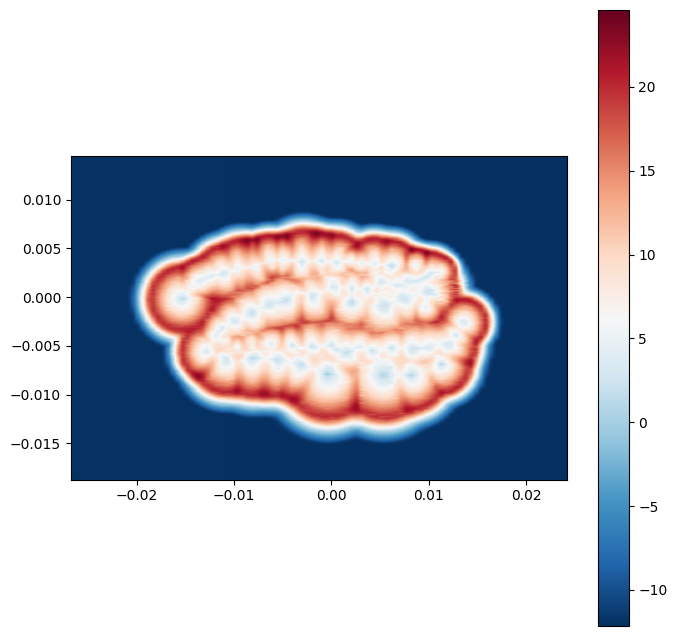

In [8]:
from core import riemannian_metric
from core import custom_geodesics
metric = riemannian_metric.Riemannian_metric(model_VAE_RBF)

latent_means_np = latent_means.detach().numpy()

print("construct solver graph")
GRAPH_DATA = KMeans(n_clusters=64, n_init=30, max_iter=1000).fit(latent_means_np).cluster_centers_
solver_graph = custom_geodesics.SolverGraph(metric, data=GRAPH_DATA, kNN_num=5, tol=1e-2)

c0 = np.array([[0.01], [-0.0095]])
c1 = np.array([[0.007], [0]])

print("Compute geodesic")
# compute geodesic
curve_graph, logmap_graph, curve_length_graph, failed_graph, solution_graph \
= custom_geodesics.solver_graph(solver_graph, metric, c0, c1)

# plot measure on latent space
latent_means_np = latent_means.detach().numpy()
z1min, z2min = latent_means_np.min(0) - 0.01
z1max, z2max = latent_means_np.max(0) + 0.01
fig, ax = plt.subplots(figsize=(8, 8))
# ax.set_xticks([])
# ax.set_yticks([])
offset=0

metric.plot_MZ(np.linspace(z1min-offset, z1max+offset, 100), np.linspace(z2min-offset, z2max+offset, 500),vae_rbfn=True)

plt.show()

/tmp/ipykernel_2058/192104246.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([c0[0, 0], c1[0, 0]], [c0[1, 0], c1[1, 0]], 'k--', c=(0,0,0),linewidth=2, label = 'Linear interpolation')


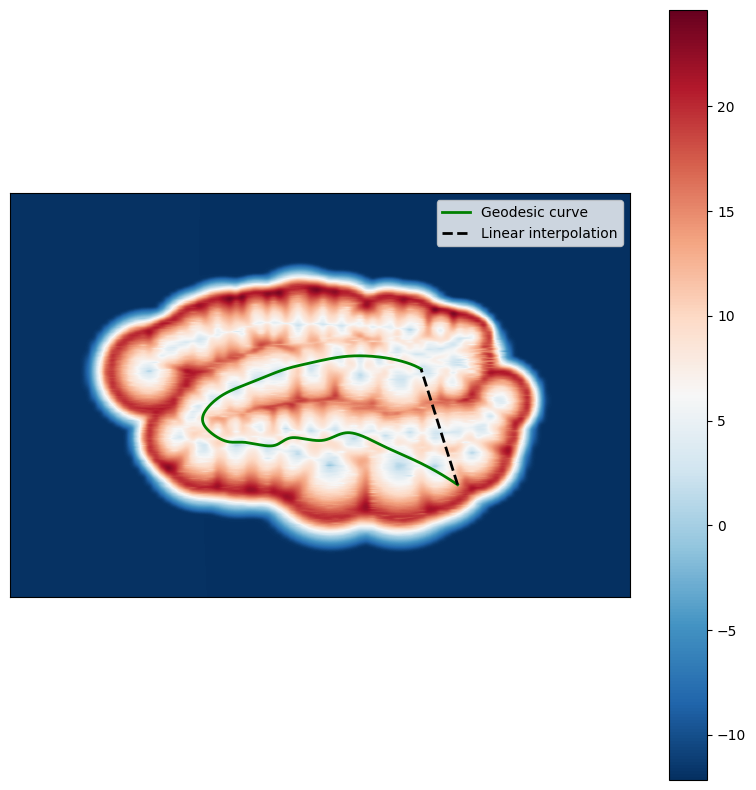

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
T = np.linspace(0, 1, 1000)
curve_eval = curve_graph(T)[0]
plt.plot(curve_eval[0, :], curve_eval[1, :], c='g', linewidth=2, label = 'Geodesic curve')
plt.plot([c0[0, 0], c1[0, 0]], [c0[1, 0], c1[1, 0]], 'k--', c=(0,0,0),linewidth=2, label = 'Linear interpolation')
ax.set_xticks([])
ax.set_yticks([])
offset=0
plt.legend()

linspace_x1 = np.linspace(z1min-offset, z1max+offset, 100)
linspace_x2 = np.linspace(z2min-offset, z2max+offset, 500)

X1, X2 = np.meshgrid(linspace_x1, linspace_x2)
X = np.concatenate((np.expand_dims(X1.flatten(), axis=1), np.expand_dims(X2.flatten(), axis=1)), axis=1)
M_z = metric.compute_riemannian_metric(torch.Tensor(X),var_rbfn= True)
M_z = M_z.detach().numpy()
N = M_z.shape[0]
img_plot = np.zeros((N, 1))
for n in range(N):
    img_plot[n] = np.sqrt(np.abs(np.linalg.det(np.squeeze(M_z[n, :, :]))))
img_plot = img_plot.reshape(X1.shape)

if True:
    # to better vizualize small differences in the determinant
    img_plot = np.log(img_plot + 1e-10)

img_plot = plt.imshow(img_plot, interpolation='gaussian', origin='lower',
        extent=(linspace_x1.min(), linspace_x1.max(), linspace_x2.min(), linspace_x2.max()),
        cmap="RdBu_r", aspect='equal')

# Adding a colorbar
cbar = plt.colorbar(img_plot)

# metric.plot_MZ(np.linspace(z1min-offset, z1max+offset, 100), np.linspace(z2min-offset, z2max+offset, 500),vae_rbfn=True)
plt.show()

/home/tdanielou/Code/MVA/Geometric-Data-Analysis/.venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


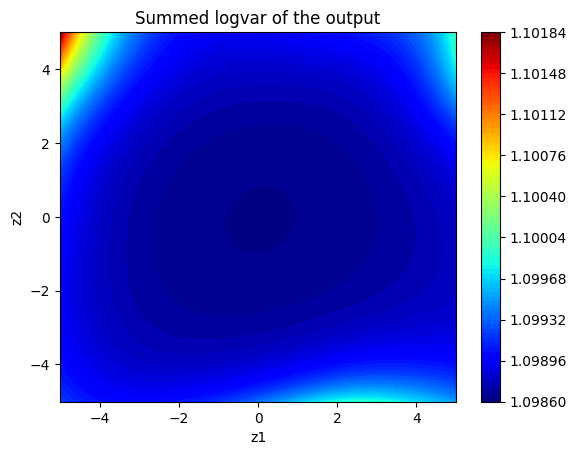

In [12]:
max_x = latent_means.max(dim=0).values[0]
max_y = latent_means.max(dim=0).values[1]
min_x = latent_means.min(dim=0).values[0]
min_y = latent_means.min(dim=0).values[1]

# plot the latent space
n=100
offset=5
x = torch.linspace(min_x-offset,max_x+offset,n)
y = torch.linspace(min_y-offset,max_y+offset,n)
X,Y = torch.meshgrid(x,y)
grid = torch.cat((X.reshape(-1,1),Y.reshape(-1,1)),dim=1)

with torch.no_grad():
    logvar_x = model_VAE_RBF.VAE.decode(grid)[1]
    summed_logvar_x = torch.log(torch.sum(torch.exp(logvar_x/2),dim=1))
    #summed_logvar_x = torch.sum(logvar_x,dim=1)
    summed_logvar_x = summed_logvar_x.reshape(X.shape)
    plt.figure()
    plt.contourf(X,Y,summed_logvar_x,levels=100,cmap='jet')
    plt.colorbar()
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Summed logvar of the output')
    plt.show()

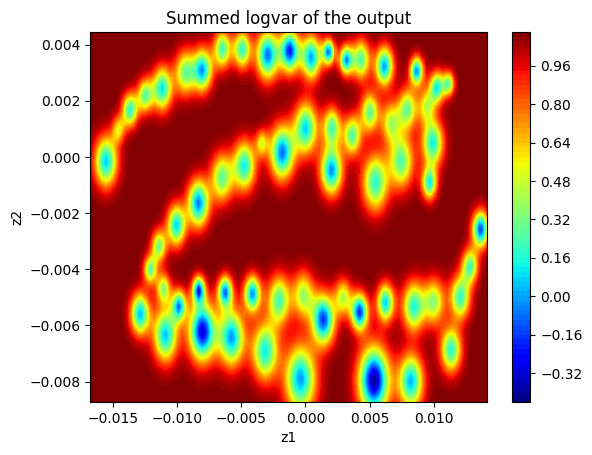

In [13]:
max_x = latent_means.max(dim=0).values[0]
max_y = latent_means.max(dim=0).values[1]
min_x = latent_means.min(dim=0).values[0]
min_y = latent_means.min(dim=0).values[1]

# plot the latent space
n=100
offset=5
x = torch.linspace(min_x,max_x,n)
y = torch.linspace(min_y,max_y,n)
X,Y = torch.meshgrid(x,y)
grid = torch.cat((X.reshape(-1,1),Y.reshape(-1,1)),dim=1)

with torch.no_grad():
    logvar_x = model_VAE_RBF.forward_RBF(grid)
    summed_logvar_x = torch.log(torch.sum(1/torch.exp(logvar_x/2),dim=1))
    summed_logvar_x = summed_logvar_x.reshape(X.shape)
    plt.figure()
    plt.contourf(X,Y,summed_logvar_x,levels=100,cmap='jet')
    plt.colorbar()
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Summed logvar of the output')
    plt.show()